# Arsenic Contamination Example

In [1]:
from IPython.display import display, HTML
display(HTML('<a target="_blank" href="https://colab.research.google.com/github/WaterFutures/EPyT-Flow/blob/main/docs/examples/arsenic_contamination.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>'))

This example demonstrates how to add a simple arsenic contamination event to a scenario.

[EPyT-Flow](https://github.com/WaterFutures/EPyT-Flow) is available on [PyPI](https://pypi.org/project/epyt-flow/) and can be installed via `pip install epyt-flow`:

In [2]:
%pip install epyt-flow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.5/240.5 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.4/888.4 kB 49.3 MB/s eta 0:00:00


In [3]:
import numpy as np
from epyt_flow.data.benchmarks import load_leakdb_scenarios
from epyt_flow.simulation import ScenarioSimulator, EpanetConstants, ScenarioConfig
from epyt_flow.simulation.events import SpeciesInjectionEvent
from epyt_flow.utils import to_seconds

Create a new scenario based on the first Net1 [LeakDB](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.data.benchmarks.html#module-epyt_flow.data.benchmarks.leakdb) scenario -- we also add an additional EPANET-MSX configuration file `arsenic_contamination.msx`:

In [4]:
config, = load_leakdb_scenarios(scenarios_id=["1"], use_net1=True, verbose=False)
config = ScenarioConfig(scenario_config=config,
                        f_msx_in="arsenic_contamination.msx")

/tmp/Net1.inp: 100%|##########| 5.90k/5.90k [00:00<00:00, 7.21MB/s]


In [5]:
sim = ScenarioSimulator(scenario_config=config)

Set simulation duration to 21 days by calling [set_general_parameters()](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.simulation.html#epyt_flow.simulation.scenario_simulator.ScenarioSimulator.set_general_parameters) -- note that all time durations have to be stated in seconds, the function [to_seconds()](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.html#epyt_flow.utils.to_seconds) can convert minutes/hours/days to seconds:

In [6]:
sim.set_general_parameters(simulation_duration=to_seconds(days=21))

Place some chlorine sensors and also keep track of the contaminant:

In [7]:
cl_sensor_locations = ["10", "11", "12", "13", "21", "22", "23", "31", "32"]
all_nodes = sim.sensor_config.nodes

sim.set_bulk_species_node_sensors({"Chlorine": cl_sensor_locations,
                                   # Also: Keep track of the contaminant
                                   "AsIII": all_nodes})   # Arsenite

Create a 1-day contamination event of an Arsenite injection (100 mg/day) at node "22" by creating a new instance of the [SpeciesInjectionEvent](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.simulation.events.html#epyt_flow.simulation.events.quality_events.SpeciesInjectionEvent) class and calling [add_system_event()](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.simulation.html#epyt_flow.simulation.scenario_simulator.ScenarioSimulator.add_system_event):

In [8]:
contamination_event = SpeciesInjectionEvent(species_id="AsIII", node_id="22",
                                            profile=np.array([100]),
                                            source_type=EpanetConstants.EN_MASS,
                                            start_time=to_seconds(days=3),
                                            end_time=to_seconds(days=4))

sim.add_system_event(contamination_event)

Run the entire simulation by calling [run_simulation()](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.simulation.html#epyt_flow.simulation.scenario_simulator.ScenarioSimulator.run_simulation):

In [9]:
scada_data = sim.run_simulation()

Inspect simulation results -- i.e. plot sensor readings over time by calling the [plot_bulk_species_node_concentration](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.simulation.scada.html#epyt_flow.simulation.scada.scada_data.ScadaData.plot_bulk_species_node_concentration) function:

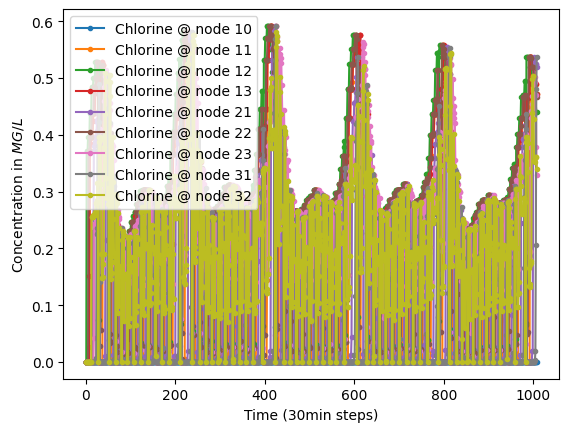

<Axes: xlabel='Time (30min steps)', ylabel='Concentration in $MG/L$'>

In [10]:
scada_data.plot_bulk_species_node_concentration({"Chlorine": cl_sensor_locations})

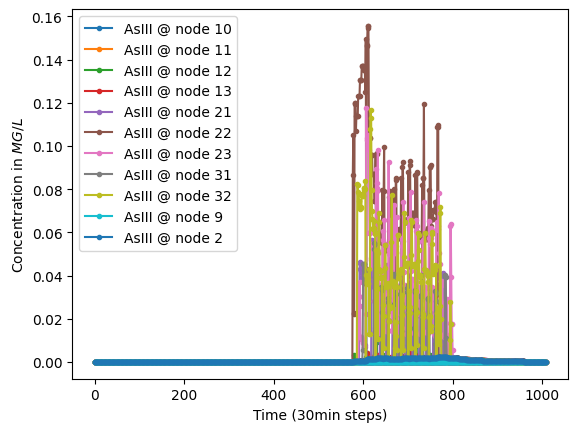

<Axes: xlabel='Time (30min steps)', ylabel='Concentration in $MG/L$'>

In [11]:
scada_data.plot_bulk_species_node_concentration({"AsIII": all_nodes})

Do not forget to close the simulation by calling [close()](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.simulation.html#epyt_flow.simulation.scenario_simulator.ScenarioSimulator.close):

In [12]:
sim.close()